#### Problem Statement: 
For given text sequence, can we predict the for which subject i.e Chemistry, Maths, Biology, or Physics.

#### Importing important library

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

#### Data Preparation 

In [104]:
#Define a custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_seq_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize and convert to indices
        tokens = text.split()
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        # Pad sequences
        if len(indices) < self.max_seq_len:
            indices = indices + [self.vocab['<PAD>']] * (self.max_seq_len - len(indices))
        else:
            indices = indices[:self.max_seq_len]
        return torch.tensor(indices), torch.tensor(label)

In [105]:
df=pd.read_csv("subjects-questions.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the data

In [106]:
# Take only 5000 data 
df=df[:5000]
df.tail()

,eng,Subject
4995,An electrical technician requires a\ncapacitan...,Physics
4996,Which is common in respiration and photosynthe...,Biology
4997,The co-ordination number of a metal in\nco-ord...,Chemistry
4998,The ratio of acceleration due to gravity\nat a...,Physics
4999,When \( C l_{2} \) water is added to an aqueou...,Chemistry


In [109]:
### Number of different Subjects
df["Subject"].unique()

array(['Physics', 'Chemistry', 'Maths', 'Biology'], dtype=object)

In [110]:
# Build vocabulary for text
max_len=0
vocab = {'<PAD>': 0, '<UNK>': 1}
for text in df['eng']:
    for token in text.split():
        token=token.lower()
        if token not in vocab:
            vocab[token] = len(vocab)

In [111]:
# Encode labels
labels=list(df["Subject"])
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [112]:
# Split data into training and validation sets ( 70 % train, 30% validation set)
texts=list(df["eng"])
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.3, random_state=42)

In [116]:
labels=list(df["Subject"])[0:10]
labels[0:10]

['Physics',
 'Chemistry',
 'Chemistry',
 'Maths',
 'Biology',
 'Physics',
 'Maths',
 'Maths',
 'Chemistry',
 'Maths']

In [115]:
labels[0:10]

array([3, 1, 1, 2, 0, 3, 2, 2, 1, 2])

#### Multi-head Self Attention Layer Model( Transformer Encoder Layer with Fully Connected Layer)

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_len, d_model))
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.positional_encoding[:seq_len, :]

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, max_seq_len, num_classes, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(max_seq_len, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc1=nn.Linear(d_model,256)
        self.fc2=nn.Linear(256,128)
        self.fc3 = nn.Linear(128,num_classes)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)
        #x = self.layer_norm(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Hyperparameters
vocab_size = len(vocab)
d_model = 64
num_heads = 8
num_layers = 2
max_seq_len = 128
num_classes = len(label_encoder.classes_)
batch_size = 32
num_epochs = 30
learning_rate = 1e-4

# Create datasets and dataloaders
train_dataset = TextDataset(texts_train, labels_train, vocab, max_seq_len)
val_dataset = TextDataset(texts_val, labels_val, vocab, max_seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model
model = Transformer(vocab_size, d_model, num_heads, num_layers, max_seq_len, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/Users/faiyazahmad/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [48]:
# Model Architecture details
model

Transformer(
  (embedding): Embedding(23311, 64)
  (positional_encoding): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_feature

### Model Training

In [49]:
# Training loop
initial_positional_encodings=model.positional_encoding.positional_encoding.detach().numpy().copy()
training_loss=[]
validation_loss=[]
validation_accuracy=[]
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        criterion=nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss.append(running_loss/len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_loss.append(val_loss/len(val_loader))
    validation_accuracy.append(correct / total)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")
final_positional_encodings=model.positional_encoding.positional_encoding.detach().numpy().copy()


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.72it/s]


Epoch [1/30], Loss: 1.3285
Validation Loss: 1.2967, Validation Accuracy: 38.27%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.77it/s]


Epoch [2/30], Loss: 1.2960
Validation Loss: 1.2601, Validation Accuracy: 40.07%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.78it/s]


Epoch [3/30], Loss: 1.2627
Validation Loss: 1.2433, Validation Accuracy: 46.47%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.85it/s]


Epoch [4/30], Loss: 1.2399
Validation Loss: 1.2027, Validation Accuracy: 47.73%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.79it/s]


Epoch [5/30], Loss: 1.2118
Validation Loss: 1.1834, Validation Accuracy: 42.27%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.81it/s]


Epoch [6/30], Loss: 1.1668
Validation Loss: 1.1229, Validation Accuracy: 50.73%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.77it/s]


Epoch [7/30], Loss: 1.1013
Validation Loss: 1.0554, Validation Accuracy: 55.93%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.77it/s]


Epoch [8/30], Loss: 1.0636
Validation Loss: 1.0274, Validation Accuracy: 56.07%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.73it/s]


Epoch [9/30], Loss: 1.0253
Validation Loss: 1.0006, Validation Accuracy: 56.27%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.78it/s]


Epoch [10/30], Loss: 0.9928
Validation Loss: 1.0434, Validation Accuracy: 52.33%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.76it/s]


Epoch [11/30], Loss: 0.9688
Validation Loss: 0.9640, Validation Accuracy: 59.13%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.79it/s]


Epoch [12/30], Loss: 0.9487
Validation Loss: 0.9604, Validation Accuracy: 58.67%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.79it/s]


Epoch [13/30], Loss: 0.9177
Validation Loss: 0.9632, Validation Accuracy: 57.60%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.82it/s]


Epoch [14/30], Loss: 0.8947
Validation Loss: 0.9399, Validation Accuracy: 59.27%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.82it/s]


Epoch [15/30], Loss: 0.8689
Validation Loss: 0.9222, Validation Accuracy: 61.27%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.77it/s]


Epoch [16/30], Loss: 0.8471
Validation Loss: 0.8995, Validation Accuracy: 62.73%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.84it/s]


Epoch [17/30], Loss: 0.8257
Validation Loss: 0.8955, Validation Accuracy: 62.00%


100%|█████████████████████████████████████████| 110/110 [00:21<00:00,  5.02it/s]


Epoch [18/30], Loss: 0.8042
Validation Loss: 0.8903, Validation Accuracy: 63.33%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.88it/s]


Epoch [19/30], Loss: 0.7703
Validation Loss: 0.8940, Validation Accuracy: 64.00%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.78it/s]


Epoch [20/30], Loss: 0.7385
Validation Loss: 0.8910, Validation Accuracy: 63.67%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.78it/s]


Epoch [21/30], Loss: 0.7353
Validation Loss: 0.8880, Validation Accuracy: 64.27%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.79it/s]


Epoch [22/30], Loss: 0.7001
Validation Loss: 0.8832, Validation Accuracy: 64.73%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.82it/s]


Epoch [23/30], Loss: 0.6824
Validation Loss: 0.8822, Validation Accuracy: 64.80%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.81it/s]


Epoch [24/30], Loss: 0.6642
Validation Loss: 0.8888, Validation Accuracy: 64.80%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.81it/s]


Epoch [25/30], Loss: 0.6449
Validation Loss: 0.8821, Validation Accuracy: 64.67%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.82it/s]


Epoch [26/30], Loss: 0.6293
Validation Loss: 0.8637, Validation Accuracy: 66.67%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.79it/s]


Epoch [27/30], Loss: 0.6050
Validation Loss: 0.9107, Validation Accuracy: 62.87%


100%|█████████████████████████████████████████| 110/110 [00:22<00:00,  4.84it/s]


Epoch [28/30], Loss: 0.5907
Validation Loss: 0.8661, Validation Accuracy: 66.87%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.78it/s]


Epoch [29/30], Loss: 0.5599
Validation Loss: 0.8579, Validation Accuracy: 66.27%


100%|█████████████████████████████████████████| 110/110 [00:23<00:00,  4.74it/s]


Epoch [30/30], Loss: 0.5434
Validation Loss: 0.8715, Validation Accuracy: 66.67%


#### Visualizing the Training vs Validation Loss and validation accuracy

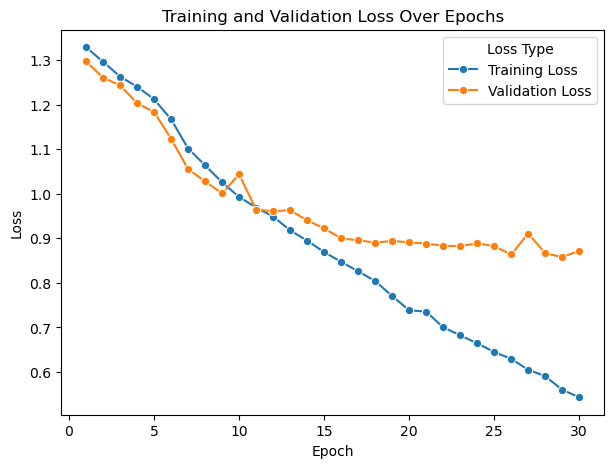

In [123]:
#### Visualization of training, validation loss
x=[i+1 for i in range(0,num_epochs)]
# Combine data into a DataFrame
data = pd.DataFrame({
    'Epoch': x,
    'Training Loss': training_loss,
    'Validation Loss': validation_loss
})

# Melt the DataFrame to long-form
data_melted = data.melt(id_vars=['Epoch'], value_vars=['Training Loss', 'Validation Loss'],
                        var_name='Loss Type', value_name='Loss')

# Plot using Seaborn
plt.figure(figsize=(7,5))
sns.lineplot(data=data_melted, x='Epoch', y='Loss', hue='Loss Type', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.show()

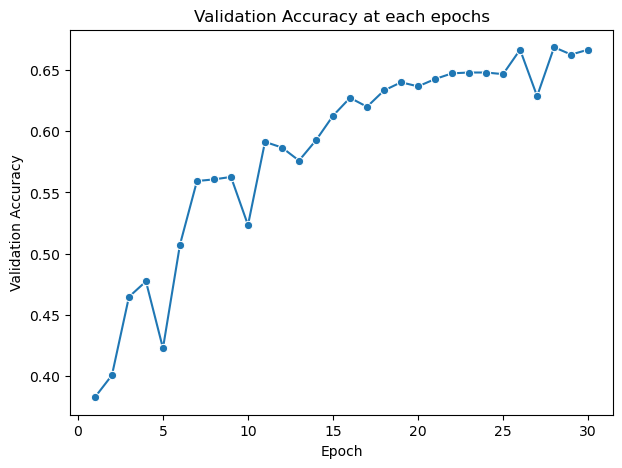

In [130]:
# Plot using Seaborn
plt.figure(figsize=(7,5))
sns.lineplot(x=x, y=validation_accuracy, marker='o')
plt.title('Validation Accuracy at each epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

### Visualizing the Learned Positional Encoding

In [125]:
### Initial positional encoding for '0' index position in sequence ( This is initialized randomly)
initial_positional_encodings[0]

array([-0.8292689 , -0.40304855, -0.0720434 , -0.27324596, -0.42888063,
       -0.716838  , -0.40736347, -0.00440647,  0.32306987, -0.27632168,
        0.10202568, -0.8778907 ,  0.18734866, -0.34482327, -1.3974146 ,
        0.48217985,  0.02559096, -0.28000286,  0.81016624, -0.92299026,
        0.637571  ,  2.576903  , -1.617014  ,  1.4501323 , -0.5712062 ,
       -0.59345686,  1.9919403 ,  1.1785048 , -0.5351334 , -0.37816644,
        0.10282379,  2.7124543 , -1.0451972 ,  0.02296072, -0.5117333 ,
        0.02977937,  0.07319611, -0.34227696, -0.12376603,  0.9572331 ,
       -0.00789497,  1.5787551 , -0.90378964, -1.1572462 , -1.034859  ,
        0.03674366, -0.4013853 , -0.13048269,  0.9275683 ,  0.07714554,
       -1.3460909 ,  1.1176661 , -0.4964064 , -1.1345931 ,  0.31628048,
        0.65811473, -1.3285292 ,  0.26423708,  1.3275645 , -1.7610738 ,
       -0.28284165,  0.02804404,  0.7207609 , -0.732721  ], dtype=float32)

In [126]:
### Final positional encoding for '0' index position in sequence ( After running the 30 epochs)
final_positional_encodings[0]

array([-0.8454805 , -0.38526672, -0.08493332, -0.29474849, -0.43305466,
       -0.7288659 , -0.43820557, -0.00686736,  0.30882034, -0.2713434 ,
        0.12330204, -0.8610024 ,  0.17340916, -0.3315462 , -1.3781036 ,
        0.45855713,  0.03467004, -0.29573897,  0.79110086, -0.9372233 ,
        0.6543137 ,  2.5521562 , -1.6245695 ,  1.4366064 , -0.58558184,
       -0.5955834 ,  2.0201972 ,  1.1562918 , -0.5605443 , -0.36518025,
        0.08321931,  2.7056808 , -1.0636885 ,  0.00488415, -0.52747947,
        0.03519943,  0.10664079, -0.35064927, -0.14041217,  0.94389623,
       -0.01791368,  1.558817  , -0.88902277, -1.1655947 , -1.0225405 ,
        0.02825371, -0.39749658, -0.10682822,  0.9108547 ,  0.08691549,
       -1.3238521 ,  1.1419272 , -0.51814735, -1.1110724 ,  0.3401083 ,
        0.67077804, -1.3149837 ,  0.26382   ,  1.3211321 , -1.7336078 ,
       -0.26981932,  0.03952186,  0.7398419 , -0.7418793 ], dtype=float32)

From above it is clear that value of positional encoding has changed for each embedding vector position for given index. We can say that it is learning how to represent the positional encoding for given task. 

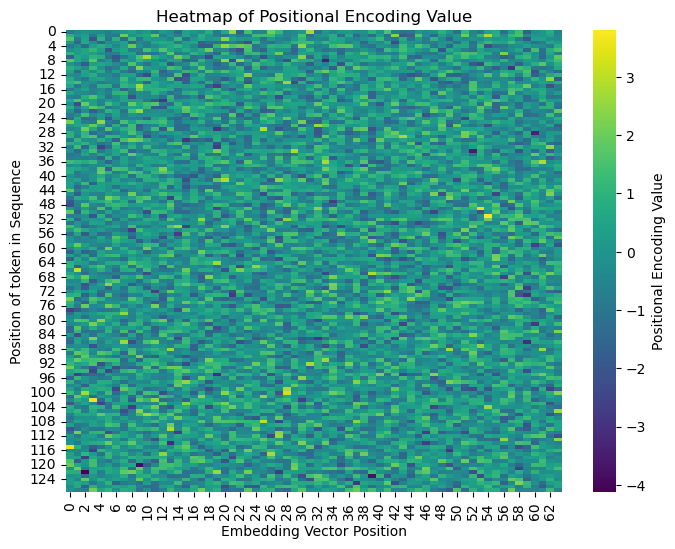

In [100]:
# Convert to DataFrame
df = pd.DataFrame(data)
# Pivot the DataFrame
pivot_table = df.pivot(index='y', columns='x', values='val')
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(final_positional_encodings, annot=False, cmap="viridis", cbar_kws={'label': 'Positional Encoding Value'})
plt.title("Heatmap of Positional Encoding Value")
plt.xlabel("Embedding Vector Position")
plt.ylabel("Position of token in Sequence")
plt.show()

From above it is clear that for each position in sequence and embedding vector position, it has learned different values. So, we can say that it is actually learned the positional representation. 